In [1]:
# Library of my own functions
import sys
sys.path.append("../../src/")
import my_functions

# Libraries to deal with dataframes and formats
import pandas as pd 
import pickle as pkl

# Libraries to plot
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Avoids no critical warnings
plt.rcParams['figure.figsize'] = [20, 4] # Change figure size of the cell of the notebook

##  1.Compare All Models

How do we compare multiple models? 

#### Metrics
At the beginning of the project, we have to establish and optimizing metric and some satisfying metrics.

- Optimizing metric

During development, we need to try a lot of ideas about algorithm architecture, model parameters, choice of features, etc. Having a single-number evaluation metric allows us to sort all models according to this metric, and quickly decide what is the best.

For this specific problem, my optimizing metric is F1-score weighted, because it helps with the problem of the data-imbalance assigning equals weights to each class. In simple words, F1-score is the harmonic mean of precision and recall (The closer to 1 the better)

- Satisfying Metric

Define what is acceptable for the model and what is not. For example, Maximum running time of the model, false positive rate, false negative, etc. You only need to meet a certain value.

#### Complexity of the model
In general is better to have a less complex model that is explainable and that someone can understand, than having a complex model that is not explainable like a Neural Network.

##### Note:
-This part is highly inspired by Andrew Ng Coursera specialization in Deep Learning

### 1.1 Optimizing Metric

In [4]:
# Calculate optimizing metric for all models
predicted_columns = ["Predicted_SupportVectorClassifier", "Predicted_logreg", "Predicted_GradientBoosting", "Predicted_AdaBoost"]
dic_f1score = {}

for column in predicted_columns:

    path = "../../data/predictions/pima/SMOTE/predictions_9june.csv"   

    # Calculate F1 Weighted Scores
    f1_train, f1_val, f1_test = my_functions.calculate_f1score(path, prediction_column=column, true_label_column="Outcome")

    # Save values in dictionary
    dic_f1score[column] = [f1_train, f1_val, f1_test]
    dic_f1score["split"] = ["training", "validation", "testing"]

# Convert the f1 scores to a dataframe
df = pd.DataFrame(dic_f1score)
df = pd.melt(df, id_vars = ["split"]).rename(columns = {"value":"f1_weighted", "variable":"model"})  # Tidy the df
df.sort_values(["f1_weighted","split"], ascending=False, inplace=True)  

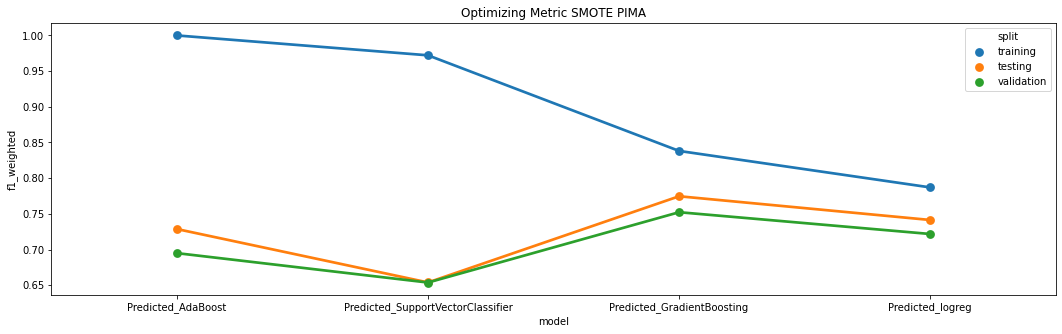

In [5]:
plt.rcParams['figure.figsize'] = [18, 5]
sns.pointplot(x="model", y="f1_weighted", data=df, hue = "split")
plt.title("Optimizing Metric SMOTE PIMA") 
plt.savefig("../../results/pima/Evaluation/SMOTE/optimization_metric.jpg")

#### Findings Optimizing Metric

- Random Forest and AdaBoost have overfitting.

### 1.2 Satisfying Metric

In [7]:
# Calculate Satisfying Metrics for All Models
predicted_columns = ["Predicted_GradientBoosting", "Predicted_AdaBoost", "Predicted_SupportVectorClassifier", "Predicted_logreg"]
dic_satisfyingmetric = {}

for column in predicted_columns:

    path = "../../data/predictions/pima/SMOTE/predictions_9june.csv"   
    # Calculate metrics
    baccuracy_train, cohen_train, baccuracy_val, cohen_val, baccuracy_test, cohen_test = my_functions.calculate_satisfying_metric(path, prediction_column=column, true_label_column="Outcome")
    
    # Put metrics in a dictionary
    dic_satisfyingmetric[column] = [baccuracy_train, cohen_train, baccuracy_val, cohen_val, baccuracy_test, cohen_test]
    dic_satisfyingmetric["metric"] = ["balanceacc_training", "cohen_training", "balanceacc_validation", "cohen_validation", "balanceacc_test", "cohen_test"]

df = pd.DataFrame(dic_satisfyingmetric)

# Obtain split and metric information
df["split"] = df['metric'].str.split('_').str[1]
df["metric"] = df['metric'].str.split('_').str[0]

# Tidy the data
df = pd.melt(df, id_vars = ["split", "metric"]).rename(columns = {"variable":"model"})  

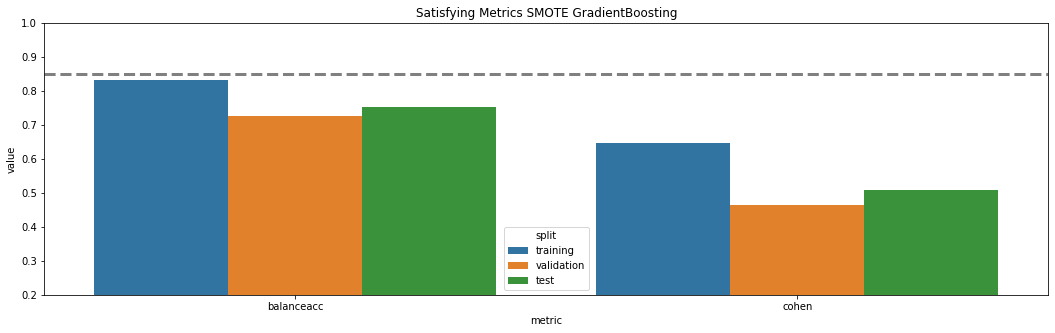

In [12]:
df_plot = df[ df["model"] =="Predicted_GradientBoosting"] # Filter the model to graph

plt.rcParams['figure.figsize'] = [18, 5]
sns.barplot(x="metric", y="value", data=df_plot, hue = "split")
plt.ylim(0.2, 1)
plt.axhline(y=0.85, linewidth=3, color='gray', linestyle='--')
plt.title("Satisfying Metrics SMOTE GradientBoosting") 
plt.savefig("../../results/pima/Evaluation/SMOTE/Gradient_Boosting/satisfying_metrics.jpg")

#### Findings Satisfying Metrics


- Balance Accuracy: It is defined as the average of recall obtained in each class (Worst is 0 and Best is 1). It gives a better option than simple accuracy in imbalanced datasets. This metric is not so bad, but it differs a lot from the training, so the model is overfitting.

- Cohen Kappa Score (Linear Weighting): Expresses the level of agreement between two annotators on a classification problem. We can say that there is not a very good agreement between the predictions and the true label.

##  2.Evaluate SVC Model

In [13]:
path = "../../data/predictions/pima/SMOTE/predictions_9june.csv"  
predicted_columns = [ "Predicted_GradientBoosting", "Predicted_AdaBoost", "Predicted_SupportVectorClassifier", "Predicted_logreg"]

#### 2.1 Confusion Matrix

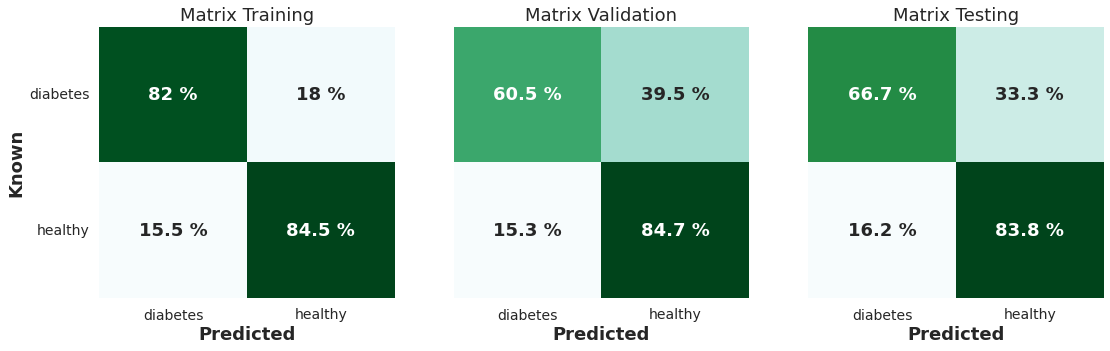

In [17]:
 plt.rcParams['figure.figsize'] = [50, 5]
 my_functions.plot_confusion_matrices(input_file=path, true_label_column="Outcome", prediction_column=predicted_columns[0])
 plt.savefig("../../results/pima/Evaluation/SMOTE/Gradient_Boosting/confusion_matrix.jpg")

#### Findings Confusion Matrix

This matrix serves to identify where the errors of the classifier are been made (Type 1 and 2 error). 
Here we see a huge difference between the training matrix and the validation matrix (Overfitting).

#### 2.2 Classification Report

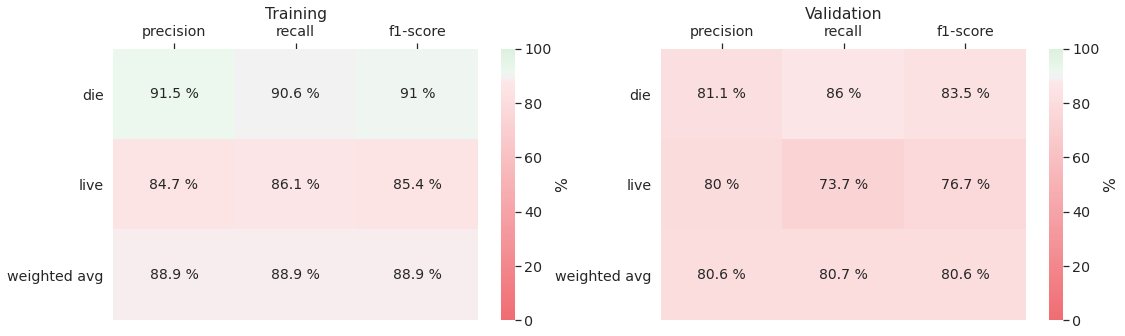

In [10]:
my_functions.plot_classification_reports(input_file)

#### Findings Classification Report

- Precision is intuitively the ability of the classifier not to label as positive a sample that is negative. 
- Recall is intuitively the ability of the classifier to find all the positive samples

I decided to use f1-score because it combines these two types of metrics. The heatmap is changed to identify where the classifier made mistakes (When it is below 90%)

#### 2.3 ROC Curves

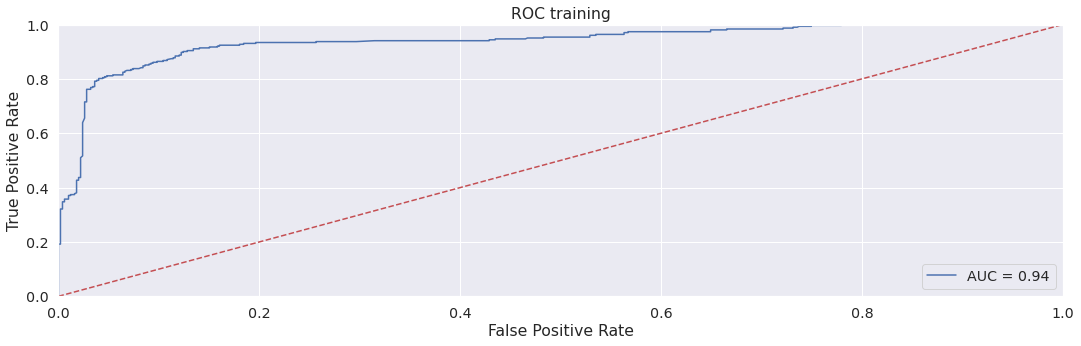

In [11]:
# Establishing parameters for ROC Curve
model = pkl.load(open("../models/features_raul/svc.pkl", 'rb'))
X, y = my_functions.create_features_target(input_file="../data/features/train_raul.pkl" , target_column="Survived", index_column="PassengerId", format_type="pickle")

# Plot ROC Curve
my_functions.plot_roc_curve(model, X, y, title = "ROC training")

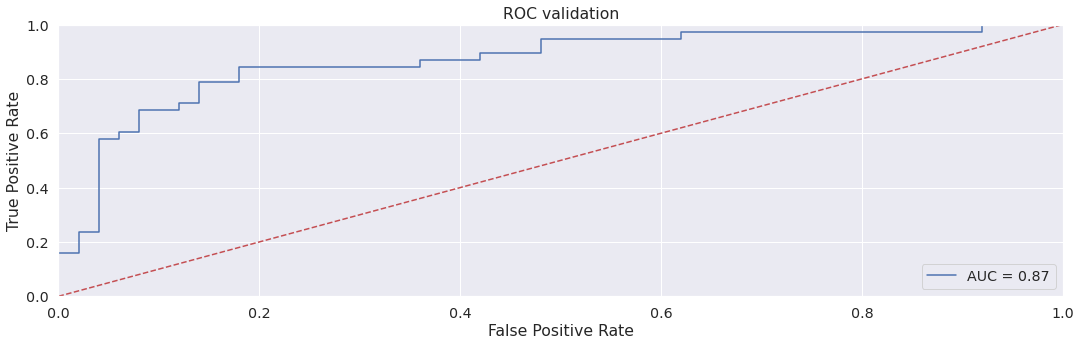

In [12]:
# Establishing parameters for ROC Curve
model = pkl.load(open("../models/features_raul/svc.pkl", 'rb'))
X, y = my_functions.create_features_target(input_file="../data/features/val_raul.pkl" , target_column="Survived", index_column="PassengerId", format_type="pickle")

# Plot ROC Curve
my_functions.plot_roc_curve(model, X, y, title = "ROC validation")

#### Findings ROC Curve

The AUC tells how much model is capable of distinguishing between classes is the metric of the area under the curve (Worst is 0 and Best is 1)

Here the model is not very good in AUC of the validation set, because it differs a lot from the training set.